In [1]:
# Para visuzalización en notebook
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['font.size'] = 22
from IPython.display import Audio, Markdown, Image
import seaborn as sns

# Números y Datos
import numpy as np
import pandas as pd

# Archivos
import urllib.request
import glob

# Machine learning
# importar los paquetes para clustering

In [2]:
import random
import csv
import scipy.stats as st
from scipy.stats import zscore

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz

# Trabajo Práctico 1

# Integrantes:
- Emiliano Beltrame
- Martin Castro
- Javier Alonso Duque
- Lucas Pecina

## Carga y preprocesamiento:
### Carga metadata, audio_features y audio_analysis
En primer lugar cargamos los 3 conjuntos de datos que tenemos disponibles para trabajar

In [3]:
metadata = pd.read_csv('metadata.csv', index_col='id')
audio_features = pd.read_csv('audio_features.csv', index_col='id')

audio_analysis_files = glob.glob('audio_analysis/timbre/*')
audio_analysis = []
for filename in audio_analysis_files:
    audio_analysis.append( pd.read_csv(filename, index_col='start') )

## Clustering
### Primera aproximacion KMeans
Utilizando solo las variables continuas realizamos un primer clustering de KMeans
Lo realizaremos con los datos de audio_features y audio_analysis por separado y luego en conjunto.

Buscaremos el k optimo con los metodos de SSE y Silhouette

#### Realizamos el filtrado de variables numericas para Audio Features (AF)

In [4]:
#audio_features.head()
#Selecciono las variables numericas
audio_features_filtro=audio_features[['acousticness','danceability','duration_ms','energy','instrumentalness','key',
                                      'liveness','loudness','mode','speechiness','tempo','time_signature']]

af_std=audio_features_filtro.apply(zscore)
af_std.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature
id,,,,,,,,,,,,
5i2sgqnzaxYpvXmGAB592h,1.020239,0.449745,-0.392481,-1.029845,-1.300295,-1.488774,-0.231088,-0.516235,0.903954,-0.205105,0.212158,0.303630
4mGzm5ahHxMX5IhVWbU7cl,1.010052,0.221832,-0.417492,-1.265002,-1.303436,-0.355693,-0.488797,-1.178182,0.903954,0.002865,0.041103,0.303630
4DEn3hZzSs9MFwFNDla5Y5,1.101731,-0.223633,-0.806927,-0.899546,1.022131,-0.072423,1.044891,-0.854780,-1.106251,-0.467408,-0.620113,-1.556946
5P6vo51dtkBYWXswH1twvK,-0.973784,0.123415,1.992726,1.033216,0.494522,1.060659,3.244854,0.466306,-1.106251,1.625400,0.270690,2.164206
29TZQMVLv25CBm3bYn2EIQ,-0.306563,0.076797,0.048504,0.189378,1.001641,1.343929,-0.413370,0.120310,-1.106251,-0.512374,-0.249576,0.303630


#### Realizamos el filtrado de variables numericas para Audio Analysis (AA)

Este conjunto de datos contine las variables continuas de bajo nivel estimadas en vetanas temporales. Dado que las canciones tienen distintas duraciones, lo que se hace es calcular el promedio de las variables por canciones.

In [5]:
items = []
items_1={}
for i in range(0,len(audio_analysis)):
    #items.append(audio_analysis[i].mean())
    items_1=np.transpose(pd.DataFrame(audio_analysis[i].mean()))
    items.append(items_1)

audio_analysis_filtro=pd.concat(items)

aa_std = audio_analysis_filtro.apply(zscore)
aa_std.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,1.684559,1.427134,0.878156,0.913863,1.235725,-0.374374,0.039880,0.240994,-0.248528,1.310129,-0.307511,-0.515035
0,1.567751,1.117248,-0.332077,0.155590,0.587707,-1.157032,0.200848,-0.119834,-1.391049,0.084937,0.002993,-0.117212
0,-0.671032,-0.721798,1.012578,-0.316574,0.488246,0.042984,0.116986,-0.119672,1.753290,-0.440985,0.047073,-1.416465
0,-1.844885,-1.333698,0.387999,0.404079,2.580445,0.085515,-1.081328,0.586926,-1.441948,-0.779218,0.946592,-0.851020
0,0.729677,0.868692,0.474267,1.231448,-0.114804,-1.270126,1.369950,-0.130370,-1.709034,-0.501788,1.009422,1.092649


#### Realizamos la union de AF & AA en un unico dataset

In [6]:
#len(af_std)
#len(aa_std)
# Ambos datasets tienen distinta dimension.
# Adicionalmente estan desordenados, procedemos a unirlos por el ID
files=pd.DataFrame(audio_analysis_files)
files['id']=files[0].str.replace('audio_analysis\/timbre\\\\', '')
files['id']=files['id'].str.replace('.csv', '')
files.set_index('id', inplace=True)
files.head()

aa_std.index=files.index
aa_std.head()

df=pd.merge(af_std, aa_std, left_index=True, right_index=True)
df.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,...,2,3,4,5,6,7,8,9,10,11
id,,,,,,,,,,,,,,,,,,,,,
5i2sgqnzaxYpvXmGAB592h,1.020239,0.449745,-0.392481,-1.029845,-1.300295,-1.488774,-0.231088,-0.516235,0.903954,-0.205105,...,-0.724843,-0.975375,1.015942,0.967481,-0.429289,-1.109052,0.226151,0.150125,-1.134449,0.380442
4mGzm5ahHxMX5IhVWbU7cl,1.010052,0.221832,-0.417492,-1.265002,-1.303436,-0.355693,-0.488797,-1.178182,0.903954,0.002865,...,-1.245715,-1.415072,0.776084,0.724246,-1.781229,0.245056,0.100889,-0.098735,-0.345130,-0.007777
4DEn3hZzSs9MFwFNDla5Y5,1.101731,-0.223633,-0.806927,-0.899546,1.022131,-0.072423,1.044891,-0.854780,-1.106251,-0.467408,...,0.762581,1.132215,0.232469,0.405153,-0.779749,-0.602680,-0.665956,-0.785484,0.710032,-0.215438
5P6vo51dtkBYWXswH1twvK,-0.973784,0.123415,1.992726,1.033216,0.494522,1.060659,3.244854,0.466306,-1.106251,1.625400,...,0.575729,1.121757,-0.324358,0.015369,0.262701,0.156755,-0.134979,0.245764,0.140146,-0.276568
29TZQMVLv25CBm3bYn2EIQ,-0.306563,0.076797,0.048504,0.189378,1.001641,1.343929,-0.413370,0.120310,-1.106251,-0.512374,...,-1.161704,-0.138129,-0.552659,-0.056134,-0.122708,-0.317060,0.841862,0.121080,-0.081178,0.420891


#### Realizamos calculo de SSE

In [7]:
#inicializo tres SSE: 
sse_af = {}
sse_aa = {}
sse_df = {}
for k in range(1, 30):
    kmeans = KMeans(n_clusters=k, init='random',n_init=5,max_iter=500, random_state=0)
    kmeans.fit(af_std)
    sse_af[k] = kmeans.inertia_
    kmeans.fit(aa_std)
    sse_aa[k] = kmeans.inertia_
    kmeans.fit(df)
    sse_df[k] = kmeans.inertia_

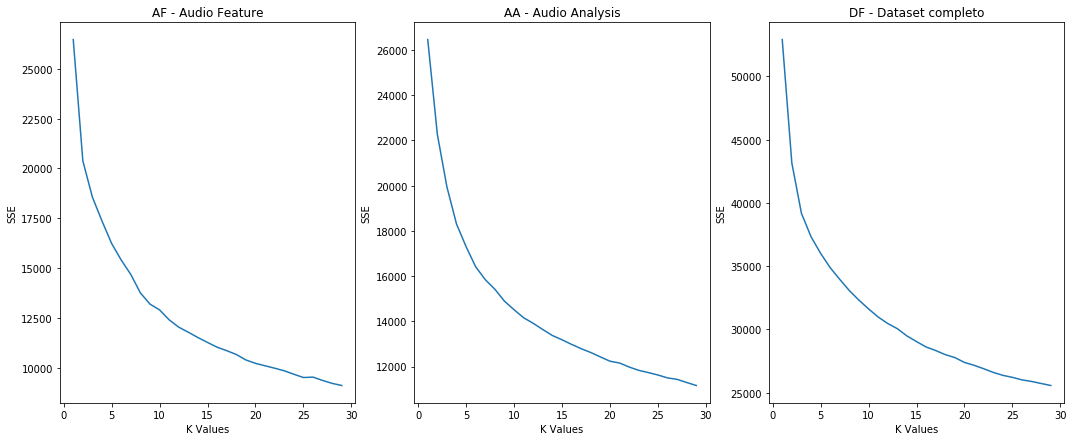

<Figure size 432x288 with 0 Axes>

In [8]:
fig, (g1, g2, g3) = plt.subplots(1, 3)
fig.set_size_inches(18, 7)    

plt.figure()
g1.plot(list(sse_af.keys()), list(sse_af.values()))
g1.set_title("AF - Audio Feature")
g1.set_xlabel("K Values")
g1.set_ylabel("SSE")
g2.plot(list(sse_aa.keys()), list(sse_aa.values()))
g2.set_title("AA - Audio Analysis")
g2.set_xlabel("K Values")
g2.set_ylabel("SSE")
g3.plot(list(sse_df.keys()), list(sse_df.values()))
g3.set_title("DF - Dataset completo")
g3.set_xlabel("K Values")
g3.set_ylabel("SSE")
plt.show()

Considerando el metodo del codo se puede decir que el numero optimo estaria en torno a k = 10

#### Realizamos el calculo por metodo de Silhouette

In [9]:
slh_af = {}
slh_aa = {}
slh_df = {}
for k in range(2, 21):
    kmeans = KMeans(n_clusters=k, init='random',n_init=5,max_iter=500, random_state=0)
    kmeans.fit(af_std)
    label = kmeans.labels_
    slh_af[k] = silhouette_score(af_std, label, metric='euclidean')
    kmeans.fit(aa_std)
    label = kmeans.labels_
    slh_aa[k] = silhouette_score(aa_std, label, metric='euclidean')
    kmeans.fit(df)
    label = kmeans.labels_
    slh_df[k] = silhouette_score(df, label, metric='euclidean')

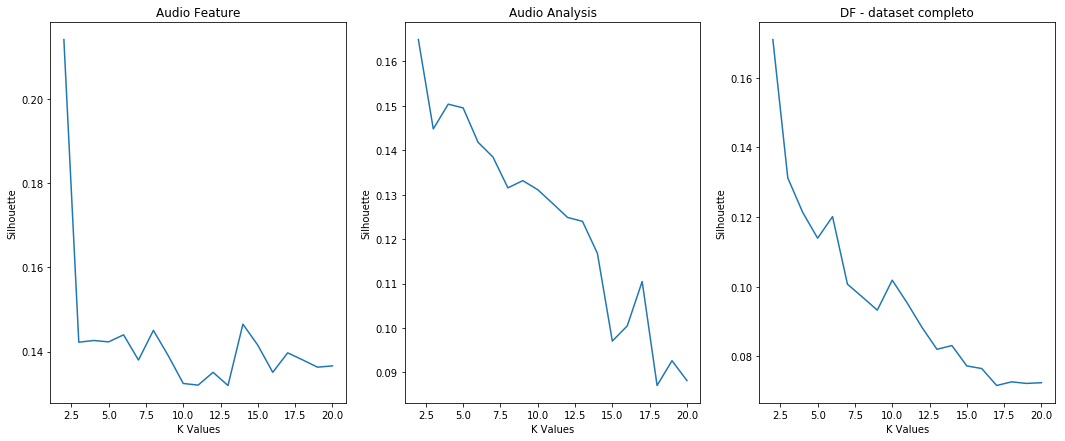

<Figure size 432x288 with 0 Axes>

In [10]:
fig, (g1, g2, g3) = plt.subplots(1, 3)
fig.set_size_inches(18, 7)    

plt.figure()
g1.plot(list(slh_af.keys()), list(slh_af.values()))
g1.set_title("Audio Feature")
g1.set_xlabel("K Values")
g1.set_ylabel("Silhouette")
g2.plot(list(slh_aa.keys()), list(slh_aa.values()))
g2.set_title("Audio Analysis")
g2.set_xlabel("K Values")
g2.set_ylabel("Silhouette")
g3.plot(list(slh_df.keys()), list(slh_df.values()))
g3.set_title("DF - dataset completo")
g3.set_xlabel("K Values")
g3.set_ylabel("Silhouette")
plt.show()

Considerando Silhouette tambien se ve que el K optimo esta en torno a 8.

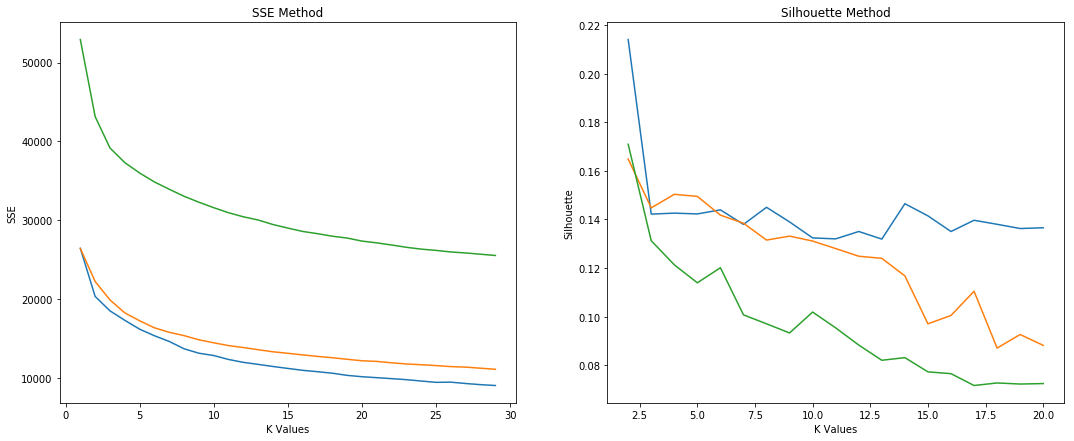

<Figure size 432x288 with 0 Axes>

In [11]:
# VUELVO A GRAFICAR PERO EN UNO SOLO
# COMPARATIVO QUIZAS ES MAS VISUAL
fig, (g1, g2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)    

plt.figure()
g1.plot(list(sse_af.keys()), list(sse_af.values()))
g1.plot(list(sse_aa.keys()), list(sse_aa.values()))
g1.plot(list(sse_df.keys()), list(sse_df.values()))
g1.set_title("SSE Method")
g1.set_xlabel("K Values")
g1.set_ylabel("SSE")
g2.plot(list(slh_af.keys()), list(slh_af.values()))
g2.plot(list(slh_aa.keys()), list(slh_aa.values()))
g2.plot(list(slh_df.keys()), list(slh_df.values()))
g2.set_title("Silhouette Method")
g2.set_xlabel("K Values")
g2.set_ylabel("Silhouette")
plt.show()

For k = 6 The average silhouette_score is : 0.14396359535475536
For k = 7 The average silhouette_score is : 0.1379783634182604
For k = 8 The average silhouette_score is : 0.14502103809096356
For k = 9 The average silhouette_score is : 0.13898681962012832
For k = 10 The average silhouette_score is : 0.13241077880388388


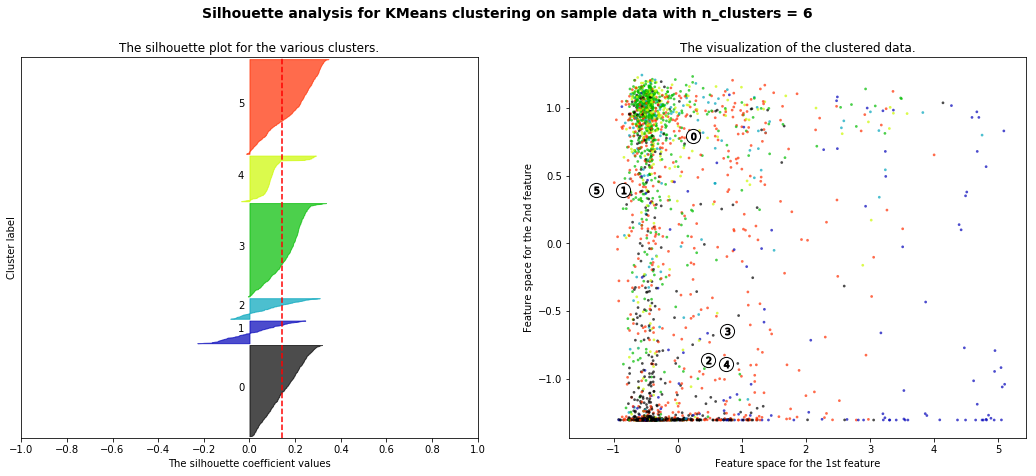

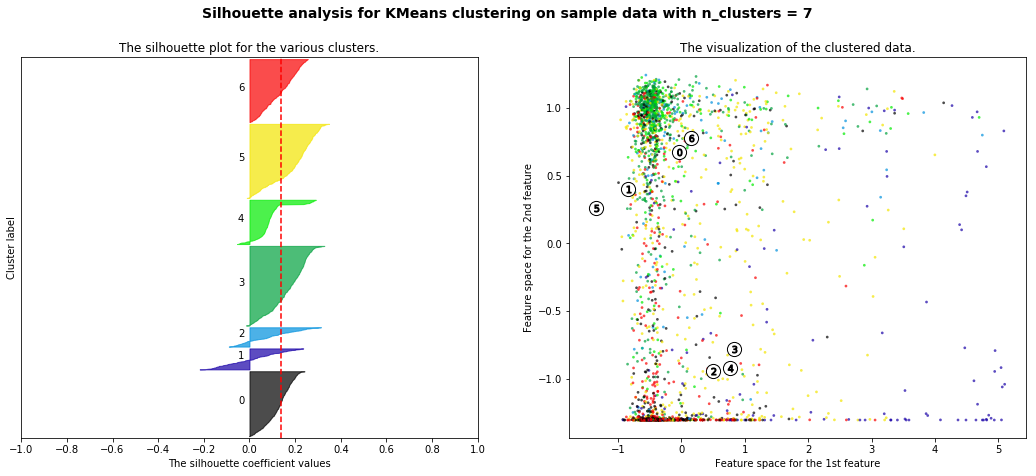

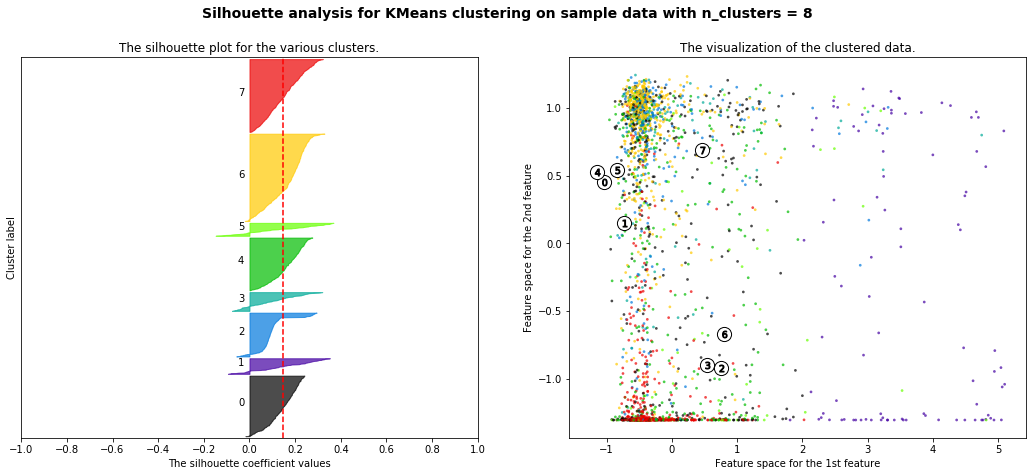

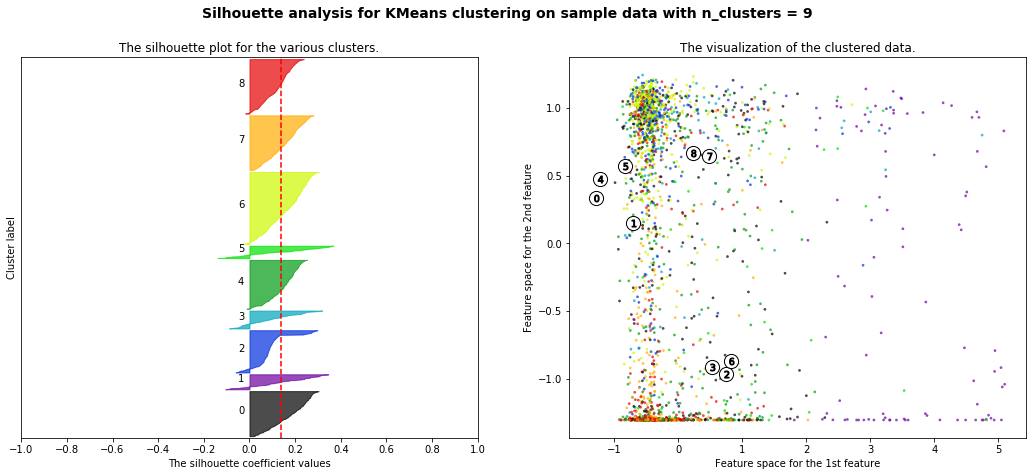

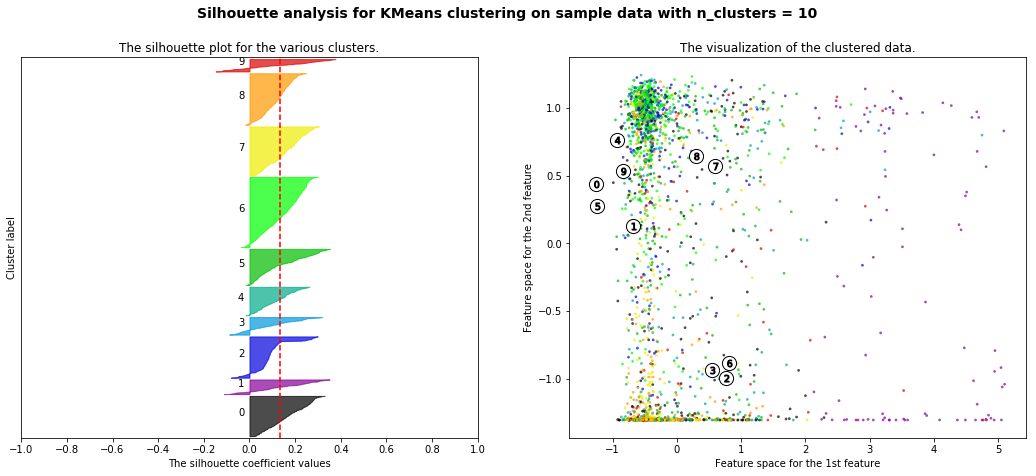

In [12]:
# Para graficar como se compone el silhouette a lo largo del cluster -solo 1 dataset
range_n_clusters = [ 6, 7, 8, 9, 10]

for k in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    ax1.set_xlim([-1, 1])
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(af_std) + (k + 1) * 10])

    # Initialize the cluster
    kmeans = KMeans(n_clusters=k, init='random',n_init=5,max_iter=500, random_state=0)
    cluster_labels = kmeans.fit_predict(af_std)

    # The silhouette_score
    silhouette_avg = silhouette_score(af_std, cluster_labels, metric='euclidean')
    print("For k =", k,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(af_std, cluster_labels)

    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # Plote the average silhouette score
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-1,-0.8,-0.6,-0.4,-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / k)
    ax2.scatter(af_std.iloc[:, 6], af_std.iloc[:, 4], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = kmeans.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % k),
                 fontsize=14, fontweight='bold')

plt.show()

Se determina que la optima cantidad de cluster son 8. 

#### Ahora procedemos a hacer los cluster con K-Means y obtenemos su matriz de confusion y otras medidas de similaridad

In [19]:
kmeans_def = KMeans(n_clusters=8, init='random',n_init=5,max_iter=500, random_state=0)
kmeans_def.fit(af_std)
label = kmeans_def.labels_

In [ ]:
#Se realiza la matriz de confusion
confusion_matrix(y_actu, y_pred)

#### Aplicacion de K-Means y evaluación de similitud

Procedemos aplicar el metodo K-Means con el K = 8 para los tres datasets (AF, AA y DF).
Transformamos el espacio de los datasets mediante componentes principales para una visualizacion grafica de los resultados

In [31]:
dataframes = ['af_std','aa_std','df']
princomp = PCA(n_components=2)
result = {}
for data in dataframes:
    kmeans = KMeans(n_clusters=8, init='random',n_init=5,max_iter=500, random_state=0)
    kmeans.fit(eval(data))
    label = kmeans.labels_
    pca = princomp.fit(eval(data)).transform(eval(data))
    pca = pd.DataFrame(pca)
    pca.index = eval(data).index
    pca['label'] = label
    result[data]=pca

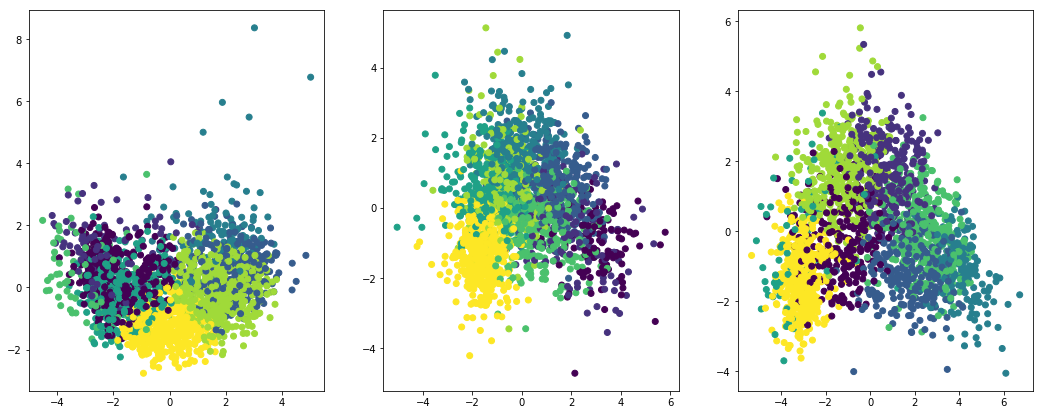

<Figure size 432x288 with 0 Axes>

In [43]:
fig, (g1, g2, g3) = plt.subplots(1, 3)
fig.set_size_inches(18, 7)    

plt.figure()
g1.scatter(result['af_std'].iloc[:, 0], result['af_std'].iloc[:, 1], c=result['af_std'].iloc[:, 2])
g2.scatter(result['aa_std'].iloc[:, 0], result['aa_std'].iloc[:, 1], c=result['aa_std'].iloc[:, 2])
g3.scatter(result['df'].iloc[:, 0], result['df'].iloc[:, 1], c=result['df'].iloc[:, 2])
g1.set_title("AF")
g1.set_title("AA")
g1.set_title("DF")
plt.show()